In [209]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer #For creating Full Pipelines

In [11]:
df = pd.read_csv("../data/train.csv")

In [12]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [14]:
def shuffle_and_split(data, test_ratio):
    np.random.seed(42) # set the seed for reproducibility
    shuffled_indices = np.random.permutation(len(data)) # this return the shuffled indices
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [15]:
train , test = shuffle_and_split(df, 0.4)

In [16]:
df = train.copy()

<h1>For Getting the Distance From Cordinates</h1>

In [18]:
locs = pd.DataFrame({
    'lat1':df['pickup_longitude'],
    'lon1':df['pickup_latitude'],
    'lat2':df['dropoff_longitude'],
    'lon2':df['pickup_latitude']
})

In [19]:

def haversine_vector(lat1, lon1, lat2, lon2, radius=6371):
    """
    Calculate the great-circle distance between two sets of coordinates
    using the Haversine formula (vectorized).

    Parameters
    ----------
    lat1, lon1 : array-like
        Latitudes & longitudes of the first set of points (in degrees).
    lat2, lon2 : array-like
        Latitudes & longitudes of the second set of points (in degrees).
    radius : float
        Earth radius in kilometers (default 6371 km). Use 3956 for miles.

    Returns
    -------
    numpy.ndarray
        Distances in kilometers (same shape as input arrays).
    """
    # Convert degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Compute differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return radius * c


In [39]:
df['distance_km'] = haversine_vector(locs.lat1, locs.lon1, locs.lat2, locs.lon2)

In [41]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,week_day,distance_km
670732,id0570804,2,2016-06-15 11:28:41,2016-06-15 13:07:17,2,-73.781631,40.644848,-73.988060,40.757236,N,5916,Wednesday,22.953805
1116926,id1240020,1,2016-02-23 07:00:39,2016-02-23 07:12:06,1,-73.985283,40.723553,-73.975433,40.755489,N,687,Tuesday,1.095220
573845,id1510937,1,2016-05-05 15:51:18,2016-05-05 16:29:14,1,-73.986282,40.742828,-73.871162,40.774216,N,2276,Thursday,12.800753
64951,id3909687,2,2016-01-31 19:31:24,2016-01-31 19:54:28,2,-73.950233,40.779861,-73.996193,40.726009,N,1384,Sunday,5.110460
35535,id3757092,1,2016-04-23 09:22:37,2016-04-23 09:25:11,1,-73.982208,40.740139,-73.977905,40.746174,N,154,Saturday,0.478469


<h1>For The Pick And Drop Time </h1>

In [51]:
def add_day_and_duration(data,pic_time):
    data[pic_time] = pd.to_datetime(data[pic_time])
    data['week_day'] = data[pic_time].dt.day_name()
    return data

In [57]:
df = add_day_and_duration(df, 'pickup_datetime')

In [61]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,week_day,distance_km
670732,id0570804,2,2016-06-15 11:28:41,2016-06-15 13:07:17,2,-73.781631,40.644848,-73.988060,40.757236,N,5916,Wednesday,22.953805
1116926,id1240020,1,2016-02-23 07:00:39,2016-02-23 07:12:06,1,-73.985283,40.723553,-73.975433,40.755489,N,687,Tuesday,1.095220
573845,id1510937,1,2016-05-05 15:51:18,2016-05-05 16:29:14,1,-73.986282,40.742828,-73.871162,40.774216,N,2276,Thursday,12.800753
64951,id3909687,2,2016-01-31 19:31:24,2016-01-31 19:54:28,2,-73.950233,40.779861,-73.996193,40.726009,N,1384,Sunday,5.110460
35535,id3757092,1,2016-04-23 09:22:37,2016-04-23 09:25:11,1,-73.982208,40.740139,-73.977905,40.746174,N,154,Saturday,0.478469


In [67]:
df['hour'] = df['pickup_datetime'].dt.hour
df['minute'] = df['pickup_datetime'].dt.minute
df['seconds'] = df['pickup_datetime'].dt.second

In [71]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,week_day,distance_km,hour,minute,seconds
670732,id0570804,2,2016-06-15 11:28:41,2016-06-15 13:07:17,2,-73.781631,40.644848,-73.988060,40.757236,N,5916,Wednesday,22.953805,11,28,41
1116926,id1240020,1,2016-02-23 07:00:39,2016-02-23 07:12:06,1,-73.985283,40.723553,-73.975433,40.755489,N,687,Tuesday,1.095220,7,0,39
573845,id1510937,1,2016-05-05 15:51:18,2016-05-05 16:29:14,1,-73.986282,40.742828,-73.871162,40.774216,N,2276,Thursday,12.800753,15,51,18
64951,id3909687,2,2016-01-31 19:31:24,2016-01-31 19:54:28,2,-73.950233,40.779861,-73.996193,40.726009,N,1384,Sunday,5.110460,19,31,24
35535,id3757092,1,2016-04-23 09:22:37,2016-04-23 09:25:11,1,-73.982208,40.740139,-73.977905,40.746174,N,154,Saturday,0.478469,9,22,37


In [73]:
df['timestamp'] = df['pickup_datetime'].astype('int64') // 10**9  # seconds

In [75]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,week_day,distance_km,hour,minute,seconds,timestamp
670732,id0570804,2,2016-06-15 11:28:41,2016-06-15 13:07:17,2,-73.781631,40.644848,-73.988060,40.757236,N,5916,Wednesday,22.953805,11,28,41,1465990121
1116926,id1240020,1,2016-02-23 07:00:39,2016-02-23 07:12:06,1,-73.985283,40.723553,-73.975433,40.755489,N,687,Tuesday,1.095220,7,0,39,1456210839
573845,id1510937,1,2016-05-05 15:51:18,2016-05-05 16:29:14,1,-73.986282,40.742828,-73.871162,40.774216,N,2276,Thursday,12.800753,15,51,18,1462463478
64951,id3909687,2,2016-01-31 19:31:24,2016-01-31 19:54:28,2,-73.950233,40.779861,-73.996193,40.726009,N,1384,Sunday,5.110460,19,31,24,1454268684
35535,id3757092,1,2016-04-23 09:22:37,2016-04-23 09:25:11,1,-73.982208,40.740139,-73.977905,40.746174,N,154,Saturday,0.478469,9,22,37,1461403357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,id1753868,2,2016-03-25 07:11:49,2016-03-25 07:33:10,2,-73.955032,40.777328,-74.006203,40.749424,N,1281,Friday,5.689883,7,11,49,1458889909
1414414,id2204747,1,2016-02-16 18:01:45,2016-02-16 18:15:38,1,-73.973618,40.763920,-73.983849,40.749874,N,833,Tuesday,1.137637,18,1,45,1455645705
131932,id3043606,2,2016-01-26 19:22:29,2016-01-26 19:43:54,1,-74.006195,40.734283,-73.949608,40.785282,N,1285,Tuesday,6.292212,19,22,29,1453836149
671155,id1458584,1,2016-01-19 11:53:47,2016-01-19 12:00:16,1,-73.962341,40.767323,-73.969757,40.768669,N,389,Tuesday,0.824596,11,53,47,1453204427


In [79]:
df['week_day'].value_counts()

week_day
Friday       134515
Saturday     132425
Thursday     131067
Wednesday    125834
Tuesday      122067
Sunday       117043
Monday       112236
Name: count, dtype: int64

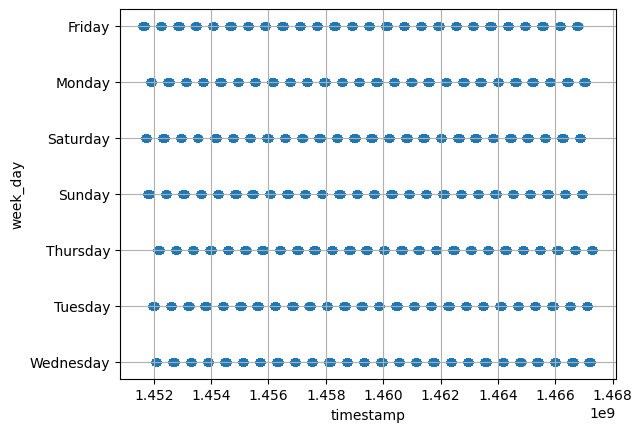

In [91]:
df.plot(kind="scatter", x="timestamp", y="week_day", grid=True, alpha=0.2)
plt.show()


<h1>Making a copies</h1>

In [98]:
temp = train.copy()

In [102]:
train = df.copy()

In [104]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,week_day,distance_km,hour,minute,seconds,timestamp
670732,id0570804,2,2016-06-15 11:28:41,2016-06-15 13:07:17,2,-73.781631,40.644848,-73.988060,40.757236,N,5916,Wednesday,22.953805,11,28,41,1465990121
1116926,id1240020,1,2016-02-23 07:00:39,2016-02-23 07:12:06,1,-73.985283,40.723553,-73.975433,40.755489,N,687,Tuesday,1.095220,7,0,39,1456210839
573845,id1510937,1,2016-05-05 15:51:18,2016-05-05 16:29:14,1,-73.986282,40.742828,-73.871162,40.774216,N,2276,Thursday,12.800753,15,51,18,1462463478
64951,id3909687,2,2016-01-31 19:31:24,2016-01-31 19:54:28,2,-73.950233,40.779861,-73.996193,40.726009,N,1384,Sunday,5.110460,19,31,24,1454268684
35535,id3757092,1,2016-04-23 09:22:37,2016-04-23 09:25:11,1,-73.982208,40.740139,-73.977905,40.746174,N,154,Saturday,0.478469,9,22,37,1461403357


In [106]:
df = temp.copy()

<h1>Extracting the 'id' for the ids in id column</h1>

In [116]:
train['id'] = train['id'].str.extract("(\d+)").astype(int)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\hp\AppData\Local\Temp\ipykernel_45960\2848822861.py:1: SyntaxWarning: invalid escape sequence '\d'
  train['id'] = train['id'].str.extract("(\d+)").astype(int)
C:\Users\hp\AppData\Local\Temp\ipykernel_45960\2848822861.py:1: SyntaxWarning: invalid escape sequence '\d'
  train['id'] = train['id'].str.extract("(\d+)").astype(int)


AttributeError: Can only use .str accessor with string values!

In [118]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,week_day,distance_km,hour,minute,seconds,timestamp
670732,570804,2,2016-06-15 11:28:41,2016-06-15 13:07:17,2,-73.781631,40.644848,-73.988060,40.757236,N,5916,Wednesday,22.953805,11,28,41,1465990121
1116926,1240020,1,2016-02-23 07:00:39,2016-02-23 07:12:06,1,-73.985283,40.723553,-73.975433,40.755489,N,687,Tuesday,1.095220,7,0,39,1456210839
573845,1510937,1,2016-05-05 15:51:18,2016-05-05 16:29:14,1,-73.986282,40.742828,-73.871162,40.774216,N,2276,Thursday,12.800753,15,51,18,1462463478
64951,3909687,2,2016-01-31 19:31:24,2016-01-31 19:54:28,2,-73.950233,40.779861,-73.996193,40.726009,N,1384,Sunday,5.110460,19,31,24,1454268684
35535,3757092,1,2016-04-23 09:22:37,2016-04-23 09:25:11,1,-73.982208,40.740139,-73.977905,40.746174,N,154,Saturday,0.478469,9,22,37,1461403357


In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875187 entries, 670732 to 121958
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  875187 non-null  int32         
 1   vendor_id           875187 non-null  int64         
 2   pickup_datetime     875187 non-null  datetime64[ns]
 3   dropoff_datetime    875187 non-null  datetime64[ns]
 4   passenger_count     875187 non-null  int64         
 5   pickup_longitude    875187 non-null  float64       
 6   pickup_latitude     875187 non-null  float64       
 7   dropoff_longitude   875187 non-null  float64       
 8   dropoff_latitude    875187 non-null  float64       
 9   store_and_fwd_flag  875187 non-null  object        
 10  trip_duration       875187 non-null  int64         
 11  week_day            875187 non-null  object        
 12  distance_km         875187 non-null  float64       
 13  hour                875187 no

In [235]:
train.drop(["pickup_datetime",axis=1 , inplace=True)
train.drop(["dropoff_datetime", "store_and_fwd_flag" ],axis=1,inplace=True)
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,week_day,distance_km,hour,minute,seconds,timestamp
670732,570804,2,2,-73.781631,40.644848,-73.988060,40.757236,5916,Wednesday,22.953805,11,28,41,1465990121
1116926,1240020,1,1,-73.985283,40.723553,-73.975433,40.755489,687,Tuesday,1.095220,7,0,39,1456210839
573845,1510937,1,1,-73.986282,40.742828,-73.871162,40.774216,2276,Thursday,12.800753,15,51,18,1462463478
64951,3909687,2,2,-73.950233,40.779861,-73.996193,40.726009,1384,Sunday,5.110460,19,31,24,1454268684
35535,3757092,1,1,-73.982208,40.740139,-73.977905,40.746174,154,Saturday,0.478469,9,22,37,1461403357


<h1>Seperating Features and labels for Dataset</h1>

In [272]:
train_features = train.drop("trip_duration", axis=1)
train_labels = train["trip_duration"].copy()

KeyError: "['trip_duration'] not found in axis"

In [274]:
train_features.head()

AttributeError: 'NoneType' object has no attribute 'head'

<h1>For Handling missing data we can use imputer : but my don't have missing values</h1>

In [147]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

<h1>Handling Categorical data : in this case ists the Week days</h1>

In [241]:
train_cat = train_features[["week_day"]]
train_cat.head()

,week_day
670732,Wednesday
1116926,Tuesday
573845,Thursday
64951,Sunday
35535,Saturday


#so for handling we use sklearn preprocessing we have ordinal and one-hot encoding and 
i will use one hot encoder as its best choice

In [175]:
cat_encoder = OneHotEncoder()
train_cathot = cat_encoder.fit_transform(train_cat) # this gives a sparse matrix(efficient storage for mostly zeros)

In [177]:
cat_encoder.categories_

[array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
        'Wednesday'], dtype=object)]

<h1>Constructing Pipelines in sklearn</h1>

Not really needed as the dataset i have dont the missing values and its standardiz

In [253]:
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [255]:
train_num = train_features.select_dtypes(include=[np.number])

In [256]:
train_num_prepared = num_pipeline.fit_transform(train_num)
print(train_num_prepared[:2].round(2))

[[-1.24  0.93  0.26  2.89 -3.16 -0.22  0.15  4.68 -0.41 -0.09  0.67  1.45]
 [-0.66 -1.07 -0.51 -0.18 -0.82 -0.03  0.1  -0.37 -1.03 -1.71  0.55 -0.74]]


In [258]:
#To turn the result back into a DataFrame with feature names:
df_train_num_prepared = pd.DataFrame(
    train_num_prepared,
    columns=num_pipeline.get_feature_names_out(),
    index=train_num.index
)

<h1>Heres the main stuff : Creating pipelines for num and cat then combining it</h1>

In [260]:
#Seperate numerical and categorical columns 
num_attribs = train_features.drop("week_day", axis=1)
cat_attribs = train_cat

In [278]:
#PipeLInes
# NUmerical pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

#Categorical pipeline
cat_pipeline = Pipeline([
    # ("ordinal", OrdinalEncoder())  # Use this if you prefer ordinal encoding
       ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Full Pipeline 
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs.columns),
    ("cat", cat_pipeline, cat_attribs.columns)
])


# Transform the data
train_prepared = full_pipeline.fit_transform(train_features)

train_prepared.shape

ValueError: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [264]:
num_attribs.info()
cat_attribs.info()
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875187 entries, 670732 to 121958
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 875187 non-null  int32  
 1   vendor_id          875187 non-null  int64  
 2   passenger_count    875187 non-null  int64  
 3   pickup_longitude   875187 non-null  float64
 4   pickup_latitude    875187 non-null  float64
 5   dropoff_longitude  875187 non-null  float64
 6   dropoff_latitude   875187 non-null  float64
 7   distance_km        875187 non-null  float64
 8   hour               875187 non-null  int32  
 9   minute             875187 non-null  int32  
 10  seconds            875187 non-null  int32  
 11  timestamp          875187 non-null  int64  
dtypes: float64(5), int32(4), int64(3)
memory usage: 73.4 MB
<class 'pandas.core.frame.DataFrame'>
Index: 875187 entries, 670732 to 121958
Data columns (total 1 columns):
 #   Column    Non-Null Count   